Notebook to show how many spin flips it takes to come to equilibrium on the Pokec network. Also use this to explore the impact of different initial conditions/parameters on the burn-in time.

To do:
- Change convention for showing the number of timesteps from $T$ to $T$/$N$ (i.e. number of spin flips per node).

Created on 06/01/20

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import random
import itertools
import matplotlib

from ising_block_level_influence import N_Block_sbm_class as NBlock
from ising_block_level_influence import projection_simplex as proj
from ising_block_level_influence import mean_field_IIM
from spatial_spin_monte_carlo import spatial_spin_monte_carlo as Spins
import Pokec_processing as  PokProc

from pokec_utils import *

### Read in processed data

This data has been generated using:

1. **make_Pokec_reduced_profiles.ipynb** - which then feeds data into:

2. The pre-processing script **'make_bratislava_graph_and_blocks.py'**.

In [2]:
graph = nx.read_graphml('Data/Bratislava_graph.graphml')
bratislava_profiles = pd.read_csv("Data/bratislava_profiles.csv")
coupling_graph = nx.read_graphml('Data/Bratislava_coupling.graphml')
block_data = pd.read_csv('Data/block_info.csv',converters={'Block' : ast.literal_eval})
mean_block_ages = list(block_data['average_age'])
block_sizes = list(block_data['block_size'])
block_names = list(block_data['block_name'])
block_data['age_group'] = [ 'ages_' + k.split('_')[-1] for k in list(block_data['block_name'])]
block_data.head()

,Unnamed: 0,block_name,block_size,average_age,age_group
0,0,Okolie_ages_1-17,1234,9.0,ages_1-17
1,1,Okolie_ages_18-21,1939,19.5,ages_18-21
2,2,Okolie_ages_22-28,3154,25.0,ages_22-28
3,3,Okolie_ages_29-112,3458,70.5,ages_29-112
4,4,Petrzalka_ages_1-17,1398,9.0,ages_1-17


In [3]:
def linear_field(x : np.ndarray,gradient :float) :
    return gradient*x

#Scale ages to [-1,1]:
rescaled_ages = [ (k-np.mean(mean_block_ages))/(max(mean_block_ages)-min(mean_block_ages)) for k in mean_block_ages ]

beta_c = Spins.crit_beta_sparse(graph)

bratislava_profiles_indices = bratislava_profiles.reset_index()
groups = [ bratislava_profiles_indices.loc[bratislava_profiles_indices['block']==block] for block in block_names]
groups_node_ids = [list(k['index']) for k in groups]

Computing critical temperature


## Generate spin series

Use the parameters used in Figure 3 of main text.

This version generates spin series for a single metastable state.

In [4]:
#Seed the random number generators:
seed = 1
random.seed(seed)
np.random.seed(seed)

beta_factor_vals = [(10**k) for k in np.linspace(-1,1.8,25)]
grad_vals = [1.0,5.0,10.0]


beta_f=8.0
gradient=1.0


T = 3000000
T_Burn = 0 # Set this as zero to return the full length in 'Run_MonteCarlo_Average'

#Field setup:

age_field = [linear_field(a,gradient) for a in rescaled_ages ]
age_field_map = {k:j for k,j in zip(list(block_data['age_group']),age_field)}
background_field = np.asarray([age_field_map[k] for k in list(bratislava_profiles['age_group'])])

# Inverse temperature: 
beta = beta_f*beta_c

relab_graph = nx.relabel.convert_node_labels_to_integers(graph)


samples=3
mc_chains=[]
for samp in range(samples) :

    # MC simulations: -VE initial condition
    initial_state = -1.0*np.ones(len(graph))
    spin_series = Run_MonteCarlo_Average(relab_graph, T, beta_f,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=background_field,initial_state=initial_state)
    mc_chains.append(spin_series)

(array([-1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65,
        -0.6 , -0.55]), <a list of 11 Text yticklabel objects>)

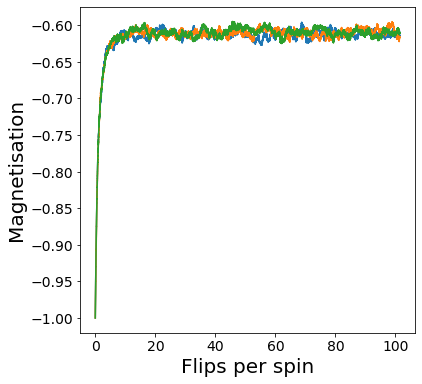

In [5]:
timesteps=np.arange(0,T,1)
flips_per_spin=[ k/len(relab_graph) for k in timesteps]

fig,ax = plt.subplots(figsize=(6,6))
for spin_series in mc_chains :
    plt.plot(flips_per_spin,spin_series)
plt.xlabel("Flips per spin",fontsize=20)
plt.ylabel("Magnetisation",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("Plots/spin_burn_in_neg_MS")